# 因子信号研究及自定义策略（4-6）

In [1]:
#读取数据：分析用数据EOSUSDT:binance，周期1H
#为了避免过拟合，把数据分为训练集和验证集，训练集上训练参数，验证集上验证训练参数是否过拟合。训练集周期20180501~20180701，验证集周期0701~
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

path = r'./min_data/VnTrader_1Min_Db'
propstrain = {'fields': 'open,high,low,close,volume','symbol': \
         'EOSUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180501000000,'end_date':20180701000000}
propsvalidation = {'fields': 'open,high,low,close,volume','symbol': \
         'EOSUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180701000000}
#train为训练集，val为验证集
Time_dict_train = ds.bar_reader(path,propstrain)  #读取数据
Time_dict_val = ds.bar_reader(path,propsvalidation)

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1Htrain = HFDataView()
dv1Hval = HFDataView()

dv1Htrain.create_init_dv(Time_dict_train['1H'].dropna().set_index(["trade_date","symbol"]))
dv1Hval.create_init_dv(Time_dict_val['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [2]:
from jaqs_fxdayu.research import TimingDigger
#定义分析函数
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

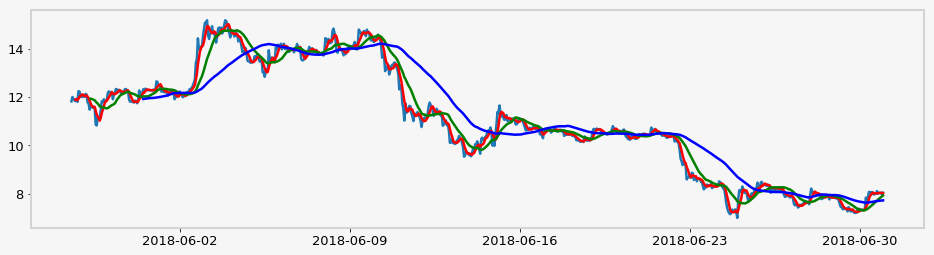

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
#画图观察，思路：先从最基础的均线策略入手，然后想办法优化均线策略
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(dv1Htrain.get_ts("close",date_type="datetime"))
ax.plot(dv1Htrain.get_ts("close",date_type="datetime").rolling(5).mean(),color='r')
ax.plot(dv1Htrain.get_ts("close",date_type="datetime").rolling(20).mean(),color='g')
ax.plot(dv1Htrain.get_ts("close",date_type="datetime").rolling(72).mean(),color='b')
plt.show()

In [4]:
#先查看基础均线策略效果
# 进场信号
long = dv1Htrain.add_formula("long","If((Ts_Mean(close,5)>Ts_Mean(close,20)) && (Delay(Ts_Mean(close,5),1)<=Delay(Ts_Mean(close,20),1)),2,0)", add_data=True)
short = dv1Htrain.add_formula("short","If((Ts_Mean(close,5)<Ts_Mean(close,20)) && (Delay(Ts_Mean(close,5),1)>=Delay(Ts_Mean(close,20),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1Htrain.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1Htrain.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')
TimingSignal(tdMa, dv1Htrain, mhp=100, sl=0.05, sp=0.3)
tdMa.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.465  -6.358   0.678
p-value              0.004   0.000   0.501
mean                 0.067  -0.022   0.006
std                  0.070   0.019   0.059
info_ratio           0.961  -1.181   0.103
skewness             0.939  -1.460   1.976
kurtosis            -0.554   1.653   3.831
pct5                 0.005  -0.058  -0.052
pct25                0.012  -0.032  -0.020
pct50                0.045  -0.013  -0.010
pct75                0.079  -0.010   0.008
pct95                0.192  -0.005   0.160
occurance           14.000  30.000  44.000
win_ratio              NaN     NaN   0.318
win_mean/loss_mean     NaN     NaN   3.008


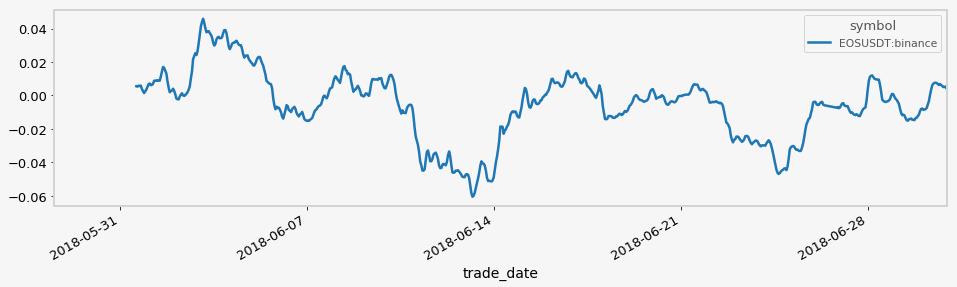

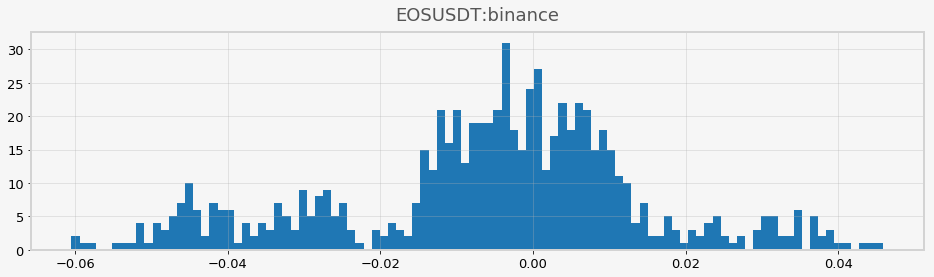

symbol  EOSUSDT:binance
count        718.000000
mean          -0.005843
std            0.020059
min           -0.060521
25%           -0.013698
50%           -0.003567
75%            0.006153
max            0.045890
symbol
EOSUSDT:binance    0.020059
dtype: float64


In [5]:
#可以看出基础均线效果不错
#优化均线策略思路1：用长期均线的斜率来过滤掉长期下跌趋势中的反弹
#定义长期均线的斜率，这里用72作为长期周期，因为一天24小时，用三天的平均作为长期均线
longma72del = dv1Htrain.add_formula("longma72del","Ts_Mean((Ts_Mean(close,72)-Delay(Ts_Mean(close,72),1)),3)", add_data=True)
#画图查看并查看统计指标
dv1Htrain.get_ts("longma72del",date_type="datetime").plot(figsize=(16,4))
dv1Htrain.get_ts("longma72del").hist(bins=100,figsize=(16,4))
plt.show()
print(dv1Htrain.get_ts("longma72del").describe())
print(dv1Htrain.get_ts("longma72del").std())

In [6]:
#由上图可以看出，均值为-0.003，成近似正态分布,标准差为0.02。那么我们过滤掉1倍标准差外面的范围，大跌趋势不做多，大涨趋势不做空
longmaf = dv1Htrain.add_formula("longmaf","If((long==2)&&(longma72del>-0.02),2,0)", add_data=True)
shortmaf = dv1Htrain.add_formula("shortmaf","If((short==-2)&&(longma72del<0.02),-2,0)",add_data=True)

tdMaf = TimingDigger(output_folder=".", output_format='pdf',signal_name='Maf')
TimingSignal(tdMaf, dv1Htrain,'longmaf','shortmaf','closeLong','closeShort', 100,0.05,)
tdMaf.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.327  -7.135   1.028
p-value              0.008   0.000   0.311
mean                 0.077  -0.019   0.011
std                  0.073   0.013   0.061
info_ratio           1.052  -1.456   0.174
skewness             0.701  -1.148   2.098
kurtosis            -1.080   0.349   3.585
pct5                 0.007  -0.044  -0.041
pct25                0.014  -0.024  -0.019
pct50                0.068  -0.013  -0.010
pct75                0.127  -0.010   0.008
pct95                0.197  -0.006   0.176
occurance           11.000  25.000  36.000
win_ratio              NaN     NaN   0.306
win_mean/loss_mean     NaN     NaN   4.124


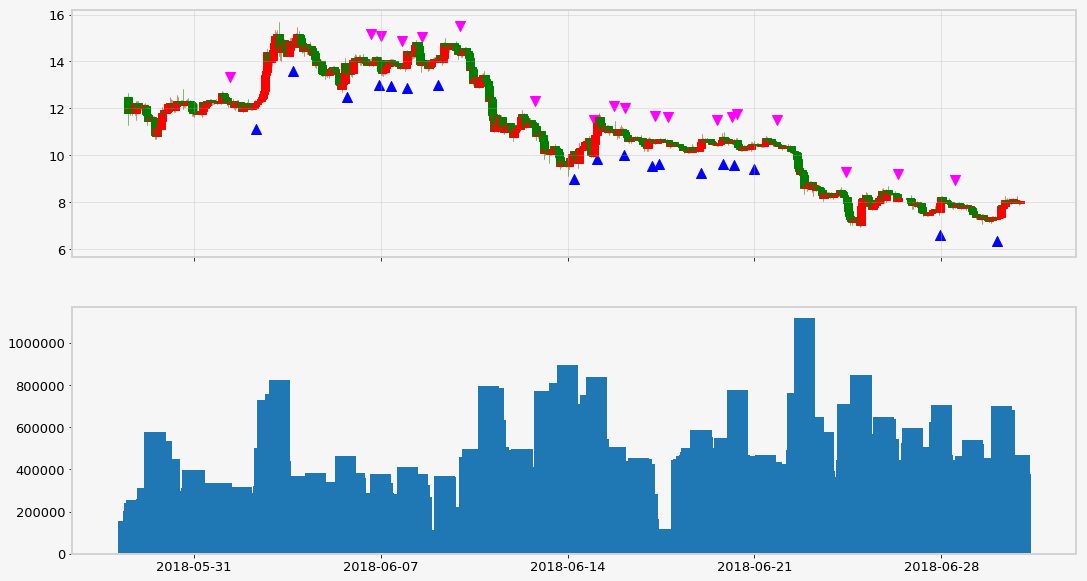

In [7]:
#可以看到效果有提升，胜率不变的情况下，盈亏比从3提升到了4. 画出进出场信号
import mpl_finance as mpf

def draw_candle_signal(candle, longX, longY,shortX,shortY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(longX, longY, color='b', s=100, marker='^')
    ax.scatter(shortX,shortY,color='magenta',s=100,marker='v')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

from matplotlib.pylab import date2num

data1H = Time_dict_train['1H'].set_index('datetime')
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

longsignal = dv1Htrain.get_ts('longmaf', date_type='datetime')
shortsignal = dv1Htrain.get_ts('shortmaf', date_type='datetime')

longX = longsignal[longsignal['EOSUSDT:binance']==2].index
longY = data1H.loc[longX].low-1
shortX = shortsignal[shortsignal['EOSUSDT:binance']==-2].index
shortY = data1H.loc[shortX].high+1

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [8]:
# 下面我们看看训练集找到的参数在验证集上表现如何
long = dv1Hval.add_formula("long","If((Ts_Mean(close,5)>Ts_Mean(close,20)) && (Delay(Ts_Mean(close,5),1)<=Delay(Ts_Mean(close,20),1)),2,0)", add_data=True)
short = dv1Hval.add_formula("short","If((Ts_Mean(close,5)<Ts_Mean(close,20)) && (Delay(Ts_Mean(close,5),1)>=Delay(Ts_Mean(close,20),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1Hval.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1Hval.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

longma72del = dv1Hval.add_formula("longma72del","Ts_Mean((Ts_Mean(close,72)-Delay(Ts_Mean(close,72),1)),5)", add_data=True)

longmaf = dv1Hval.add_formula("longmaf","If((long==2)&&(longma72del>-0.02),2,0)", add_data=True)
shortmaf = dv1Hval.add_formula("shortmaf","If((short==-2)&&(longma72del<0.02),-2,0)",add_data=True)

tdMaf = TimingDigger(output_folder=".", output_format='pdf',signal_name='Maf')
TimingSignal(tdMaf, dv1Hval,'longmaf','shortmaf','closeLong','closeShort', 100,0.05,)
tdMaf.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               4.853 -10.361    0.167
p-value              0.000   0.000    0.868
mean                 0.047  -0.023    0.001
std                  0.060   0.019    0.051
info_ratio           0.777  -1.188    0.015
skewness             1.856  -1.389    2.350
kurtosis             2.576   1.744    7.450
pct5                 0.001  -0.060   -0.059
pct25                0.009  -0.032   -0.023
pct50                0.021  -0.015   -0.011
pct75                0.057  -0.011    0.010
pct95                0.194  -0.002    0.094
occurance           40.000  77.000  117.000
win_ratio              NaN     NaN    0.342
win_mean/loss_mean     NaN     NaN    2.025


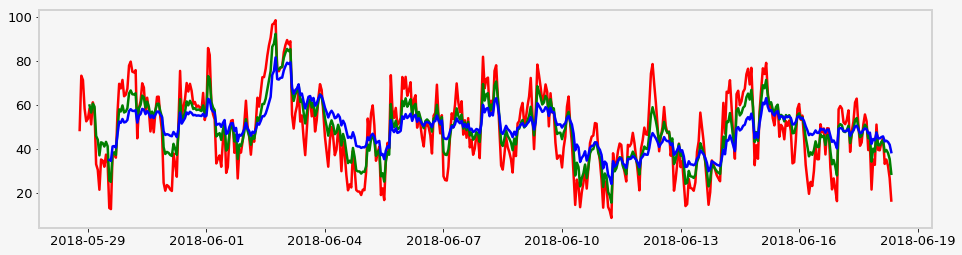

In [9]:
#优化均线策略思路2：用RSI作为过滤条件
RSI6 = dv1Htrain.add_formula("RSI6","Ta('RSI',0, open, high, low, close, volume,6)",overwrite=True,add_data=True)
RSI12 = dv1Htrain.add_formula("RSI12","Ta('RSI',0, open, high, low, close, volume,12)",overwrite=True,add_data=True)
RSI24 = dv1Htrain.add_formula("RSI24","Ta('RSI',0, open, high, low, close, volume,24)",overwrite=True,add_data=True)
RSI36 = dv1Htrain.add_formula("RSI36","Ta('RSI',0, open, high, low, close, volume,36)",overwrite=True,add_data=True)
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(dv1Htrain.get_ts("RSI6",date_type="datetime").iloc[:500],color='r')
ax.plot(dv1Htrain.get_ts("RSI12",date_type="datetime").iloc[:500],color='g')
ax.plot(dv1Htrain.get_ts("RSI24",date_type="datetime").iloc[:500],color='b')
plt.show()

In [10]:
#结合均线策略，只在RSI6>RSI24的时候做多，也只在相反的时候做空
longmarsi = dv1Htrain.add_formula("longmarsi","If((long==2)&&(RSI6>RSI12),2,0)", add_data=True)
shortmarsi= dv1Htrain.add_formula("shortmarsi","If((short==-2)&&(RSI6<RSI12),-2,0)",add_data=True)

tdMaf = TimingDigger(output_folder=".", output_format='pdf',signal_name='Maf')
TimingSignal(tdMaf, dv1Htrain,'longmarsi','shortmarsi','closeLong','closeShort', 100,0.05,)
tdMaf.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.261  -5.705   0.749
p-value              0.008   0.000   0.458
mean                 0.072  -0.021   0.007
std                  0.073   0.019   0.061
info_ratio           0.983  -1.119   0.122
skewness             0.793  -1.683   1.969
kurtosis            -0.919   2.320   3.597
pct5                 0.004  -0.060  -0.054
pct25                0.012  -0.026  -0.020
pct50                0.046  -0.013  -0.010
pct75                0.104  -0.010   0.009
pct95                0.195  -0.005   0.175
occurance           12.000  27.000  39.000
win_ratio              NaN     NaN   0.308
win_mean/loss_mean     NaN     NaN   3.389


In [11]:
#查看在验证集上的效果
RSI6 = dv1Hval.add_formula("RSI6","Ta('RSI',0, open, high, low, close, volume,6)",overwrite=True,add_data=True)
RSI12 = dv1Hval.add_formula("RSI12","Ta('RSI',0, open, high, low, close, volume,12)",overwrite=True,add_data=True)
RSI24 = dv1Hval.add_formula("RSI24","Ta('RSI',0, open, high, low, close, volume,24)",overwrite=True,add_data=True)
RSI36 = dv1Hval.add_formula("RSI36","Ta('RSI',0, open, high, low, close, volume,36)",overwrite=True,add_data=True)

longmarsi = dv1Hval.add_formula("longmarsi","If((long==2)&&(RSI6>RSI12),2,0)", add_data=True)
shortmarsi= dv1Hval.add_formula("shortmarsi","If((short==-2)&&(RSI6<RSI12),-2,0)",add_data=True)

tdMaf = TimingDigger(output_folder=".", output_format='pdf',signal_name='Maf')
TimingSignal(tdMaf, dv1Hval,'longmarsi','shortmarsi','closeLong','closeShort', 100,0.05,)
tdMaf.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               4.920 -10.374   -0.699
p-value              0.000   0.000    0.486
mean                 0.043  -0.025   -0.003
std                  0.053   0.021    0.047
info_ratio           0.809  -1.160   -0.064
skewness             1.911  -1.469    2.043
kurtosis             3.078   2.045    6.856
pct5                 0.001  -0.061   -0.059
pct25                0.010  -0.033   -0.024
pct50                0.021  -0.016   -0.011
pct75                0.055  -0.011    0.006
pct95                0.160  -0.002    0.065
occurance           38.000  81.000  119.000
win_ratio              NaN     NaN    0.319
win_mean/loss_mean     NaN     NaN    1.747


In [12]:
#可以看出效果并不太好。思考是因为RSI比MA敏感，用敏感指标去过滤滞后指标效果并不好
#优化均线策略思路3：用成交量作为过滤条件，只有在成交量放大时候的信号才采纳，因为震荡会产生很多假信号，而震荡时往往成交量不会突然放大
#一天有24小时，日内成交量变化有其周期性，所以先取平均平滑波动，再回溯24个周期
volumedelta = dv1Htrain.add_formula("volumedel","If((Ts_Mean(volume,6)>(Delay(Ts_Mean(volume,6),24))),1,0)", add_data=True)

longmav = dv1Htrain.add_formula("longmav","If((long==2)&&(volumedel==1),2,0)", add_data=True)
shortmav = dv1Htrain.add_formula("shortmav","If((short==-2)&&(volumedel==1),-2,0)",add_data=True)

tdMaV = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaV')
TimingSignal(tdMaV, dv1Htrain,'longmav','shortmav','closeLong','closeShort', 100,0.05,)
tdMaV.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              1.907 -5.273   1.107
p-value             0.129  0.001   0.288
mean                0.078 -0.012   0.020
std                 0.082  0.007   0.066
info_ratio          0.953 -1.864   0.307
skewness            0.390 -0.170   1.917
kurtosis           -1.814 -0.332   1.893
pct5                0.003 -0.022  -0.021
pct25               0.013 -0.014  -0.013
pct50               0.022 -0.011  -0.008
pct75               0.174 -0.010   0.010
pct95               0.181 -0.003   0.177
occurance           5.000  9.000  14.000
win_ratio             NaN    NaN   0.357
win_mean/loss_mean    NaN    NaN   6.460


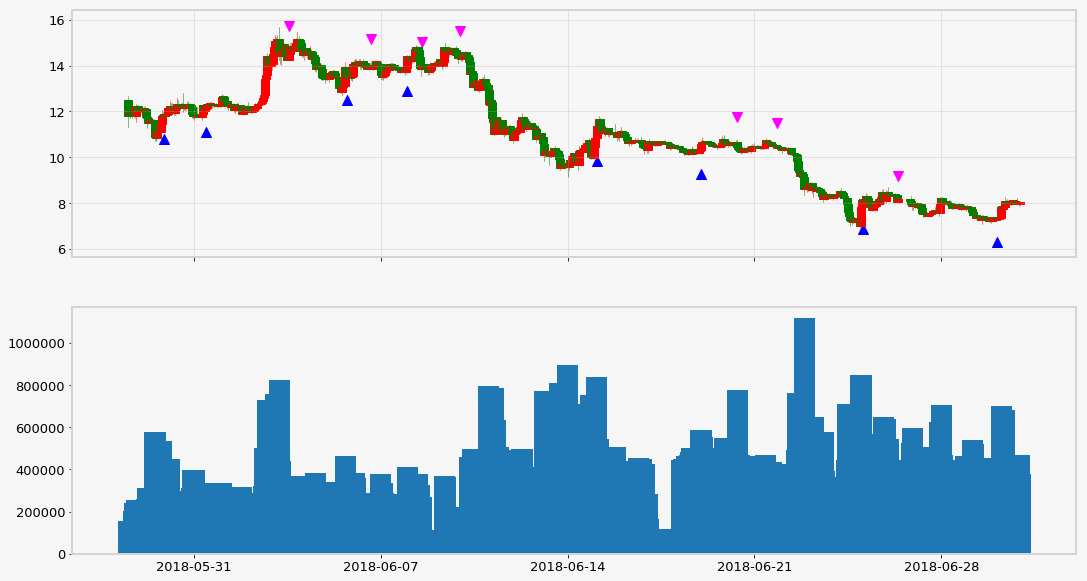

In [13]:
#可以看出效果有明显提升，画出思路3的信号：
longsignal = dv1Htrain.get_ts('longmav', date_type='datetime')
shortsignal = dv1Htrain.get_ts('shortmav', date_type='datetime')

longX = longsignal[longsignal['EOSUSDT:binance']==2].index
longY = data1H.loc[longX].low-1
shortX = shortsignal[shortsignal['EOSUSDT:binance']==-2].index
shortY = data1H.loc[shortX].high+1

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [14]:
#查看在验证集上的效果
volumedelta = dv1Hval.add_formula("volumedel","If((Ts_Mean(volume,6)>(Delay(Ts_Mean(volume,6),24))),1,0)", add_data=True)

longmav = dv1Hval.add_formula("longmav","If((long==2)&&(volumedel==1),2,0)", add_data=True)
shortmav = dv1Hval.add_formula("shortmav","If((short==-2)&&(volumedel==1),-2,0)",add_data=True)

tdMaV = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaV')
TimingSignal(tdMaV, dv1Hval,'longmav','shortmav','closeLong','closeShort', 100,0.05,)
tdMaV.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.777  -6.274   1.038
p-value              0.002   0.000   0.305
mean                 0.072  -0.027   0.011
std                  0.078   0.023   0.071
info_ratio           0.916  -1.186   0.153
skewness             0.933  -1.375   1.733
kurtosis            -0.544   1.221   2.701
pct5                 0.001  -0.074  -0.059
pct25                0.005  -0.031  -0.023
pct50                0.041  -0.020  -0.011
pct75                0.119  -0.012   0.014
pct95                0.226  -0.003   0.181
occurance           18.000  29.000  47.000
win_ratio              NaN     NaN   0.383
win_mean/loss_mean     NaN     NaN   2.654


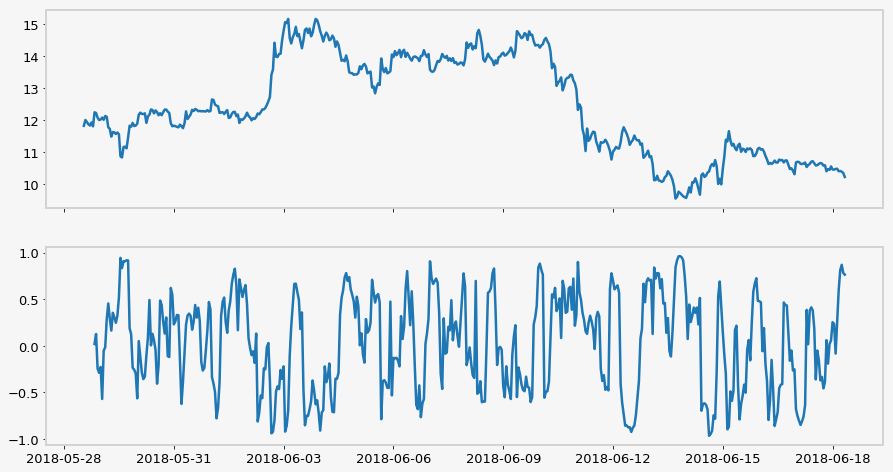

In [15]:
#以上是第一个因子：均线因子，的优化思路
#下面寻找第二个因子，并优化。从alpha101中的alpha002获取到灵感
alpha2_change = dv1Htrain.add_formula('alpha2_C','-1*Correlation(Delta(Log(volume),2),((close-open)/open),6)',add_data=True)
alpha2_plot = dv1Htrain.get_ts('alpha2_C',date_type='datetime')
close = dv1Htrain.get_ts('close', date_type='datetime')

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[:500])
    ax1.plot(alpha.iloc[:500])
    # plt.savefig('good')
    plt.show()
    
plot_chart(close,alpha2_plot)

Field [alpha2_C] is overwritten.


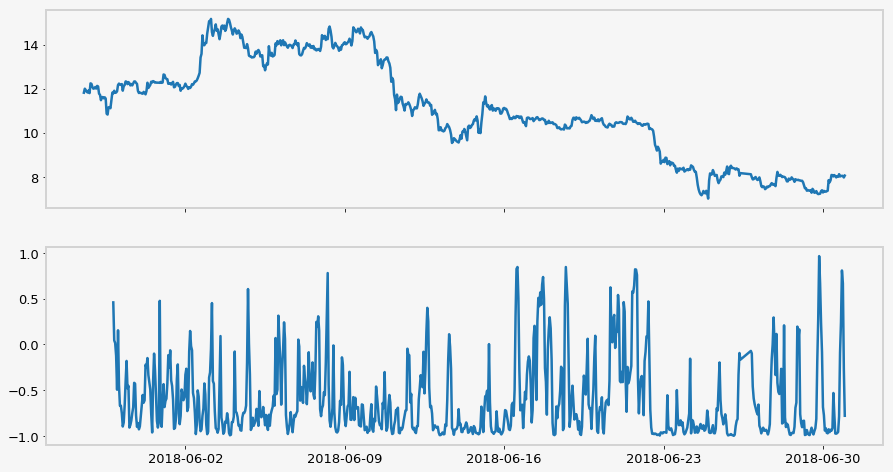

In [16]:
#上图可以看出原论文中的alpha002是非常差的因子，毫无作用。
#alpha002的思路是量价波动率的背离，那么我们如何更好的定义量价波动率的背离。也就是价格波动不大的时候，成交量突然放大。
#改进alpha002，成交量和价格的波动量要重新定义，用24小时均值的变化率的相关系数定义
alpha2_change = dv1Htrain.add_formula('alpha2_C','-1*Correlation(Delta(Log(Ts_Mean(volume,24)),2),Delta(Log(Ts_Mean((high-low)/Delay(close,1),24)),2),6)',add_data=True)
alpha2_plot = dv1Htrain.get_ts('alpha2_C',date_type='datetime')
close = dv1Htrain.get_ts('close', date_type='datetime')

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[:])
    ax1.plot(alpha.iloc[:])
    # plt.savefig('good')
    plt.show()
    
plot_chart(close,alpha2_plot)

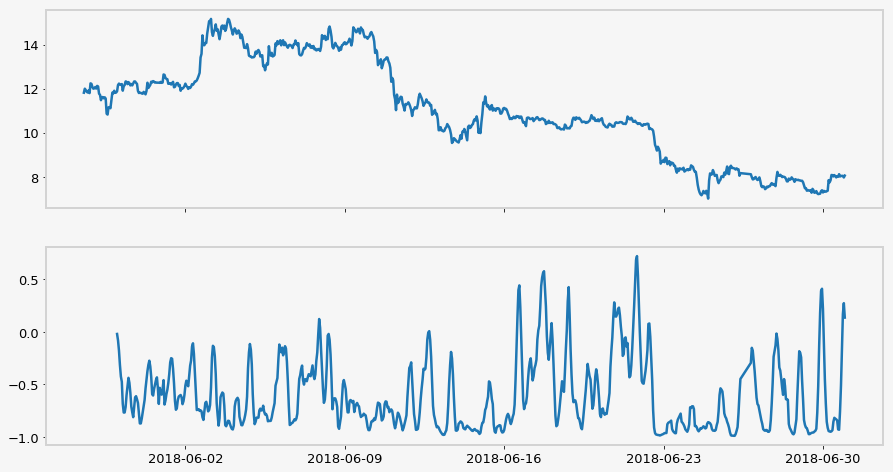

In [17]:
#毛刺太多，用均值平滑
alpha2mean = dv1Htrain.add_formula("alpha2mean","Ts_Mean(alpha2_C,5)",add_data=True)
alpha2plotmean = dv1Htrain.get_ts("alpha2mean",date_type="datetime")

plot_chart(close,alpha2plotmean)

In [18]:
#由上图可以看出，这是相当好的预测因子，每次凸起之后都预示着一波趋势的产生。但是，我们不知道趋势产生的方向
#我认为，趋势产生的方向，是与之前的中期趋势相反，那么如何定义中期趋势
#定义中期趋势思路1：参考之前的计算，用中期均线的斜率作定义，用均值平滑波动

longstdvolprice = dv1Htrain.add_formula("longstdvolprice","If((longma72del<-0.005)&&(alpha2mean>-0.2),2,0)",add_data=True)
shortstdvolprice = dv1Htrain.add_formula("shortstdvolprice","If((longma72del>0.005)&&(alpha2mean>-0.2),-2,0)",add_data=True)

close_longstd = dv1Htrain.add_formula("closeLongstd","If(longstdvolprice==-2,1,0)", add_data=True)
close_shortstd = dv1Htrain.add_formula("closeShortstd","If(shortstdvolprice==2,-1,0)", add_data=True)

tdstdvolprice = TimingDigger(output_folder=".", output_format='pdf',signal_name='tdstdvolprice')
TimingSignal(tdstdvolprice, dv1Htrain,'longstdvolprice','shortstdvolprice','closeLongstd','closeShortstd', 100,0.05,)
tdstdvolprice.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.260 -12.801   0.501
p-value              0.001   0.000   0.619
mean                 0.098  -0.057   0.008
std                  0.095   0.022   0.100
info_ratio           1.033  -2.613   0.077
skewness             0.589   1.232   1.349
kurtosis            -1.516   0.794   0.604
pct5                 0.005  -0.082  -0.080
pct25                0.024  -0.074  -0.064
pct50                0.043  -0.060  -0.035
pct75                0.223  -0.052   0.038
pct95                0.236  -0.009   0.229
occurance           18.000  25.000  43.000
win_ratio              NaN     NaN   0.419
win_mean/loss_mean     NaN     NaN   1.710


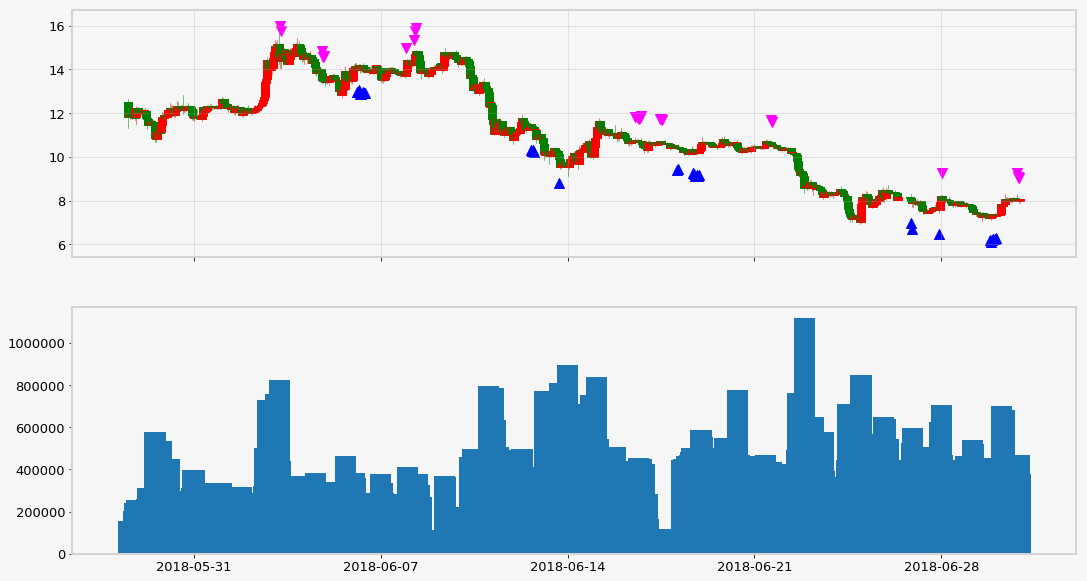

In [19]:
#画出训练集的进出场信号
longsignal = dv1Htrain.get_ts('longstdvolprice', date_type='datetime')
shortsignal = dv1Htrain.get_ts('shortstdvolprice', date_type='datetime')

longX = longsignal[longsignal['EOSUSDT:binance']==2].index
longY = data1H.loc[longX].low-1
shortX = shortsignal[shortsignal['EOSUSDT:binance']==-2].index
shortY = data1H.loc[shortX].high+1

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [20]:
alpha2_change = dv1Hval.add_formula('alpha2_C','-1*Correlation(Delta(Log(Ts_Mean(volume,24)),2),Delta(Log(Ts_Mean((high-low)/Delay(close,1),24)),2),6)',add_data=True)
alpha2mean = dv1Hval.add_formula("alpha2mean","Ts_Mean(alpha2_C,5)",add_data=True)

longstdvolprice = dv1Hval.add_formula("longstdvolprice","If((longma72del<-0.005)&&(alpha2mean>-0.2),2,0)",add_data=True)
shortstdvolprice = dv1Hval.add_formula("shortstdvolprice","If((longma72del>0.005)&&(alpha2mean>-0.2),-2,0)",add_data=True)

close_longstd = dv1Hval.add_formula("closeLongstd","If(longstdvolprice==-2,1,0)", add_data=True)
close_shortstd = dv1Hval.add_formula("closeShortstd","If(shortstdvolprice==2,-1,0)", add_data=True)

tdstdvolprice = TimingDigger(output_folder=".", output_format='pdf',signal_name='tdstdvolprice')
TimingSignal(tdstdvolprice, dv1Hval,'longstdvolprice','shortstdvolprice','closeLongstd','closeShortstd', 100,0.05,)
tdstdvolprice.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              11.057 -22.811   2.538
p-value              0.000   0.000   0.013
mean                 0.123  -0.067   0.029
std                  0.077   0.020   0.111
info_ratio           1.596  -3.327   0.259
skewness             0.194   0.617   0.602
kurtosis            -1.500   1.102  -1.032
pct5                 0.016  -0.096  -0.093
pct25                0.055  -0.085  -0.063
pct50                0.093  -0.065   0.010
pct75                0.194  -0.054   0.093
pct95                0.236  -0.051   0.233
occurance           49.000  48.000  97.000
win_ratio              NaN     NaN   0.505
win_mean/loss_mean     NaN     NaN   1.821


In [21]:
#定义中期趋势思路2，用中期RSI的数值作区分，大于50为上涨趋势，小于50为下跌趋势
longstdvolrsi = dv1Htrain.add_formula("longstdvolrsi","If((RSI6<RSI24)&&(alpha2mean>-0.3),2,0)",add_data=True)
shortstdvolrsi = dv1Htrain.add_formula("shortstdvolrsi","If((RSI6>RSI24)&&(alpha2mean>-0.3),-2,0)",add_data=True)

close_longstd = dv1Htrain.add_formula("closeLongstdrsi","If(longstdvolrsi==-2,1,0)", add_data=True)
close_shortstd = dv1Htrain.add_formula("closeShortstdrsi","If(shortstdvolrsi==2,-1,0)", add_data=True)

tdstdvolrsi = TimingDigger(output_folder=".", output_format='pdf',signal_name='tdstdvolrsi')
TimingSignal(tdstdvolrsi, dv1Htrain,'longstdvolrsi','shortstdvolrsi','closeLongstdrsi','closeShortstdrsi', 100,0.05,)
tdstdvolrsi.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               8.952 -21.076    1.120
p-value              0.000   0.000    0.265
mean                 0.121  -0.059    0.011
std                  0.094   0.024    0.107
info_ratio           1.292  -2.402    0.100
skewness             0.208   0.622    1.174
kurtosis            -1.730   0.492    0.040
pct5                 0.011  -0.100   -0.094
pct25                0.036  -0.070   -0.060
pct50                0.078  -0.059   -0.052
pct75                0.227  -0.054    0.046
pct95                0.244  -0.007    0.233
occurance           49.000  78.000  127.000
win_ratio              NaN     NaN    0.386
win_mean/loss_mean     NaN     NaN    2.063


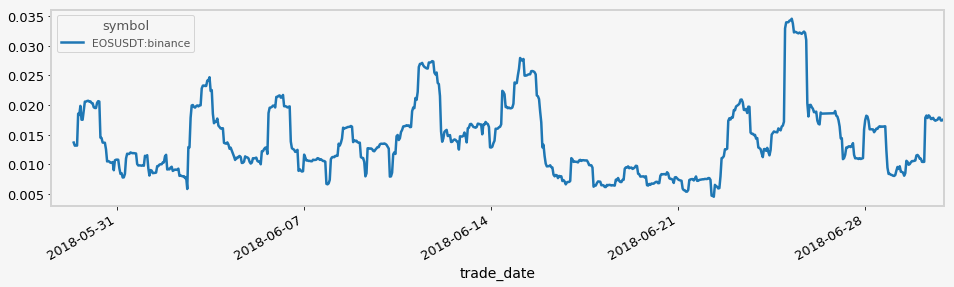

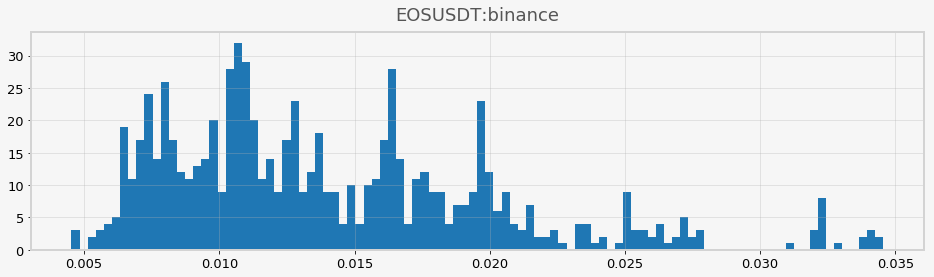

In [22]:
#定义价格波动的波动率
STD = dv1Htrain.add_formula("STD","StdDev(close/Delay(close,1)-1, 20)",add_data=True)
dv1Htrain.get_ts("STD",date_type="datetime").plot(figsize=(16,4))
dv1Htrain.get_ts("STD",date_type="datetime").hist(bins=100,figsize=(16,4))
plt.show()

In [23]:
#上面看出胜率还可以（0.4），但因为假信号太多导致盈利下降
#为了过滤掉假信号，加入价格波动率作为条件，因为我们要找出量变，价不变的时候，这时候意味着市场产生大的分歧

longstdvolrsi = dv1Htrain.add_formula("longstdvolrsi","If((RSI6<RSI24)&&(alpha2mean>-0.3)&&(STD<0.01),2,0)",add_data=True)
shortstdvolrsi = dv1Htrain.add_formula("shortstdvolrsi","If((RSI6>RSI24)&&(alpha2mean>-0.3)&&(STD<0.01),-2,0)",add_data=True)

close_longstd = dv1Htrain.add_formula("closeLongstdrsi","If(longstdvolrsi==-2,1,0)", add_data=True)
close_shortstd = dv1Htrain.add_formula("closeShortstdrsi","If(shortstdvolrsi==2,-1,0)", add_data=True)

tdstdvolrsi = TimingDigger(output_folder=".", output_format='pdf',signal_name='tdstdvolrsi')
TimingSignal(tdstdvolrsi, dv1Htrain,'longstdvolrsi','shortstdvolrsi','closeLongstdrsi','closeShortstdrsi', 100,0.05,)
tdstdvolrsi.create_event_report(sig_type="long_short")

Field [longstdvolrsi] is overwritten.
Field [shortstdvolrsi] is overwritten.
Field [closeLongstdrsi] is overwritten.
Field [closeShortstdrsi] is overwritten.
Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               8.372 -14.245   1.583
p-value              0.000   0.000   0.118
mean                 0.155  -0.056   0.022
std                  0.094   0.026   0.119
info_ratio           1.642  -2.124   0.187
skewness            -0.502   0.658   0.975
kurtosis            -1.574  -0.183  -0.679
pct5                 0.013  -0.095  -0.087
pct25                0.053  -0.070  -0.060
pct50                0.223  -0.059  -0.053
pct75                0.230  -0.054   0.069
pct95                0.250  -0.007   0.236
occurance           27.000  46.000  73.000
win_ratio              NaN     NaN   0.370
win_mean/loss_mean  

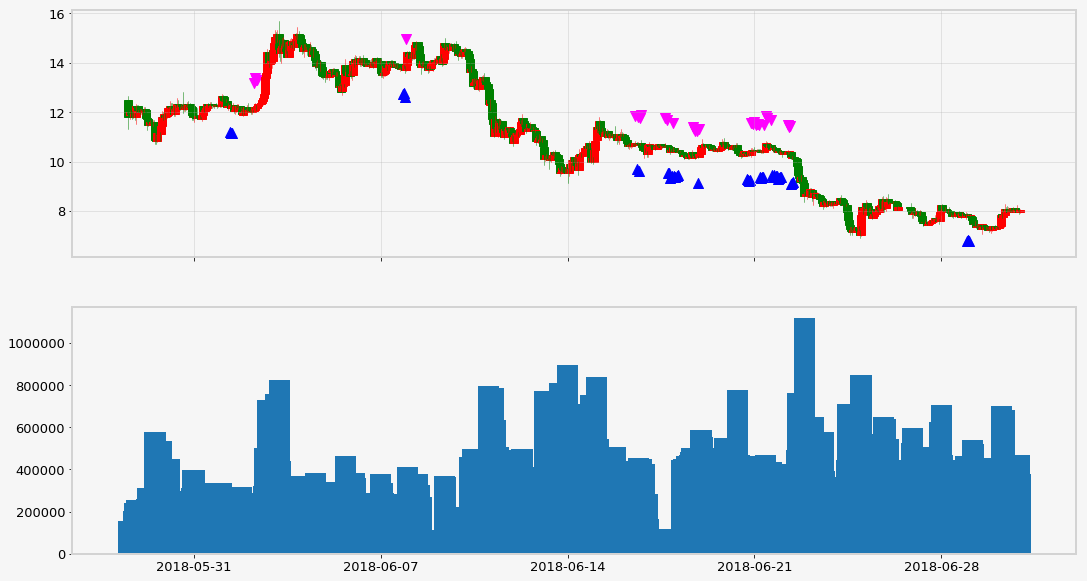

In [24]:
#可以看出，加入波动率作为过滤条件后，盈亏比有明显提升，画出在训练集的进出场信号
longsignal = dv1Htrain.get_ts('longstdvolrsi', date_type='datetime')
shortsignal = dv1Htrain.get_ts('shortstdvolrsi', date_type='datetime')

longX = longsignal[longsignal['EOSUSDT:binance']==2].index
longY = data1H.loc[longX].low-1
shortX = shortsignal[shortsignal['EOSUSDT:binance']==-2].index
shortY = data1H.loc[shortX].high+1

draw_candle_signal(candle,longX,longY,shortX,shortY)

In [25]:
#查看在验证集上的效果
STD = dv1Hval.add_formula("STD","StdDev(close/Delay(close,1)-1, 20)",add_data=True)

longstdvolrsi = dv1Hval.add_formula("longstdvolrsi","If((RSI6<RSI24)&&(alpha2mean>-0.3)&&(STD<0.01),2,0)",add_data=True)
shortstdvolrsi = dv1Hval.add_formula("shortstdvolrsi","If((RSI6>RSI24)&&(alpha2mean>-0.3)&&(STD<0.01),-2,0)",add_data=True)

close_longstd = dv1Hval.add_formula("closeLongstdrsi","If(longstdvolrsi==-2,1,0)", add_data=True)
close_shortstd = dv1Hval.add_formula("closeShortstdrsi","If(shortstdvolrsi==2,-1,0)", add_data=True)

tdstdvolrsi = TimingDigger(output_folder=".", output_format='pdf',signal_name='tdstdvolrsi')
TimingSignal(tdstdvolrsi, dv1Hval,'longstdvolrsi','shortstdvolrsi','closeLongstdrsi','closeShortstdrsi', 100,0.05,)
tdstdvolrsi.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat              23.709  -45.519    5.270
p-value              0.000    0.000    0.000
mean                 0.191   -0.065    0.053
std                  0.075    0.014    0.138
info_ratio           2.557   -4.552    0.385
skewness            -0.711   -0.206    0.457
kurtosis            -0.283    1.273   -1.509
pct5                 0.039   -0.088   -0.083
pct25                0.150   -0.074   -0.065
pct50                0.202   -0.063   -0.051
pct75                0.245   -0.053    0.198
pct95                0.283   -0.051    0.274
occurance           87.000  101.000  188.000
win_ratio              NaN      NaN    0.463
win_mean/loss_mean     NaN      NaN    2.915


## 研究结论：

综上研究可以看出，效果比较好的是1：均线成交量综合策略，2：量价波动率背离策略加波动率过滤

基本假设是:
1.均线策略(金叉做多，死叉做空）假信号太多，如果能有效过滤假信号，会得到有效果的策略。交叉时如果成交量配合放大为真信号，否则为假信号。
2.成交量意味着分歧，一般成交量越大意味着分歧越大，也就意味着变盘的产生。横盘中成交量放大，意味着很快会变盘。

基本策略：要提升策略的效果，需要结合不同的因子，过滤假信号。可以得到鲁棒性强的策略。

下面输出两个策略的绩效表

In [26]:
#1均线成交量综合策略
print("*****-Long-*****")
tdMaV.create_event_report(sig_type="long")
print("*****-Short-*****")
tdMaV.create_event_report(sig_type="short")
print("*****-Long_Short-*****")
tdMaV.create_event_report(sig_type="long_short")

*****-Long-*****
*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              1.941  -4.625   0.253
p-value             0.093   0.000   0.802
mean                0.058  -0.023   0.003
std                 0.079   0.020   0.060
info_ratio          0.734  -1.156   0.052
skewness            1.342  -1.942   2.475
kurtosis            0.419   3.199   6.706
pct5                0.001  -0.063  -0.053
pct25               0.004  -0.023  -0.020
pct50               0.015  -0.015  -0.012
pct75               0.078  -0.012   0.002
pct95               0.198  -0.003   0.115
occurance           8.000  17.000  25.000
win_ratio             NaN     NaN   0.320
win_mean/loss_mean    NaN     NaN   2.557
*****-Short-*****
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.266  -4.349   1.122
p-value              0.010   0.001   0.274
mean                 0.083  -0.033   0.020
std                  0.076   0.026   0.080
info_rat

In [27]:
#量价波动率背离策略
#long
print("*****-Long-*****")
tdstdvolrsi.create_event_report(sig_type="long")
print("*****-Short-*****")
tdstdvolrsi.create_event_report(sig_type="short")
print("*****-Long_Short-*****")
tdstdvolrsi.create_event_report(sig_type="long_short")

*****-Long-*****
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               9.007 -36.055  -0.278
p-value              0.000   0.000   0.782
mean                 0.149  -0.069  -0.003
std                  0.084   0.015   0.111
info_ratio           1.766  -4.579  -0.029
skewness            -0.135  -0.504   1.319
kurtosis            -1.385  -0.707   0.244
pct5                 0.021  -0.098  -0.093
pct25                0.083  -0.080  -0.075
pct50                0.141  -0.071  -0.054
pct75                0.219  -0.054   0.056
pct95                0.261  -0.052   0.232
occurance           27.000  63.000  90.000
win_ratio              NaN     NaN   0.300
win_mean/loss_mean     NaN     NaN   2.175
*****-Short-*****
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              26.330 -31.728   7.380
p-value              0.000   0.000   0.000
mean                 0.209  -0.060   0.105
std                  0.061   0.012 